In [1]:
# rm(list = ls())
setwd("/mnt/c/git_repos/iORD_hepatitis/")
require(tidyverse)
require(data.table)
require(lubridate)
require(foreach)
require(doParallel)
require(randomcoloR)
require(tidyquant)
require(funtimes)
require(forecast)

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The follo

### Load data

In [2]:
att_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months"),
           AttendanceMonth = cut(AttendanceStartDate, breaks = "month")) %>%
    arrange(AttendanceStartDate) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

test_df <- fread("data/IORD_ASHep-UE_34_20230120_LIMS.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           CollectionDateTime = as.Date(CollectionDateTime),
           CollectionMonth = cut(CollectionDateTime, breaks = "month"),
           CollectionTwoMonth = cut(CollectionDateTime, breaks = "2 months")) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

diag_df <- fread("data/IORD_ASHep-UE_34_20230120_DiagnosisCodes.csv") %>%
    left_join(fread("data/IORD_ASHep-UE_34_20230120_InpatientSpells.csv")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(att_df) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    arrange(AttendanceMonth) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

attendances <- att_df %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    distinct(ClusterID, AttendanceStartDate, AttendanceMonth) %>%
    group_by(AttendanceMonth) %>%
    summarise(n_attended = n())

Joining with `by = join_by(ClusterID, SpellID)`
Warning message in left_join(., fread("data/IORD_ASHep-UE_34_20230120_InpatientSpells.csv")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 148 of `x` matches multiple rows in `y`.
ℹ Row 131747 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., att_df):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 171 of `x` matches multiple rows in `y`.
ℹ Row 125173 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


### Diagnostic codes per month

#### Lack of seasonality

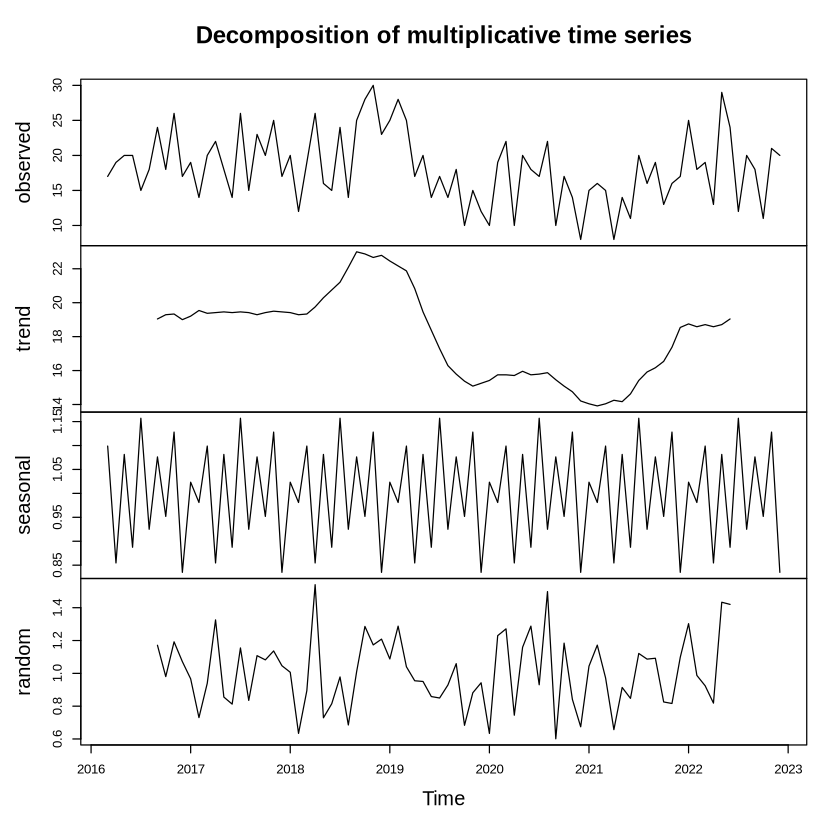

In [3]:
test <- diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceMonth, .keep_all = T) %>%
    group_by(AttendanceMonth) %>%
    summarise(n = n()) %>%
    filter(AttendanceMonth != as.Date("2023-01-01"))
timeseries <- ts(test$n, frequency = 12, start = c(2016, 3))

plot(decompose(timeseries, type = "multiplicative"))

In [4]:
# Group ICD10 codes with unspecified agent
unspecified <- c("K720", "K759", "K716", "K752", 
                 "B199", "B179", "B178")

#### Diag code counts

In [5]:
diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(is_unspecified = ifelse(DiagCode %in% unspecified, T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    group_by(is_outbreak, is_unspecified, age_group) %>%
    summarise(n = n())

diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(is_unspecified = ifelse(DiagCode %in% unspecified, T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    group_by(age_group) %>%
    filter(is_unspecified) %>%
    summarise(n = n())

diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(is_unspecified = ifelse(DiagCode %in% unspecified, T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    group_by(age_group) %>%
    summarise(n = n()) %>%
    ungroup() %>%
    mutate(prop = n / sum(n))


`summarise()` has grouped output by 'is_outbreak', 'is_unspecified'. You can override using the `.groups` argument.


is_outbreak,is_unspecified,age_group,n
<lgl>,<lgl>,<fct>,<int>
FALSE,FALSE,<7,2
FALSE,FALSE,7-15,4
FALSE,FALSE,>15,1054
FALSE,TRUE,<7,5
FALSE,TRUE,7-15,5
FALSE,TRUE,>15,295
TRUE,FALSE,>15,115
TRUE,TRUE,<7,1
TRUE,TRUE,7-15,3


age_group,n
<fct>,<int>
<7,6
7-15,8
>15,393


age_group,n,prop
<fct>,<int>,<dbl>
<7,8,0.005056890
7-15,12,0.007585335
>15,1562,0.987357775


#### Prune double diagnoses

In [6]:
diag_filt <- diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(is_unspecified = ifelse(DiagCode %in% unspecified, T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    group_by(ClusterID, AttendanceStartDate, age_group, is_outbreak) %>%
    summarise(n_spec = sum(!is_unspecified),
              n_unspec = sum(is_unspecified)) %>%
    mutate(only_unspec = ifelse(n_unspec > 0 & n_spec == 0, T, F)) %>%
    ungroup()

`summarise()` has grouped output by 'ClusterID', 'AttendanceStartDate', 'age_group'. You can override using the `.groups` argument.


In [7]:
test <- diag_filt %>%
    select(is_outbreak, only_unspec)

table(test)

fisher.test(table(test))

           only_unspec
is_outbreak FALSE TRUE
      FALSE  1029  295
      TRUE    111   96


	Fisher's Exact Test for Count Data

data:  table(test)
p-value = 2.502e-12
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.201005 4.124189
sample estimates:
odds ratio 
  3.014131 


### Overall trend in diagnoses

Warning message in geom_ma_(mapping = mapping, data = data, position = position, :
“Ignoring unknown parameters: `method`”
Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


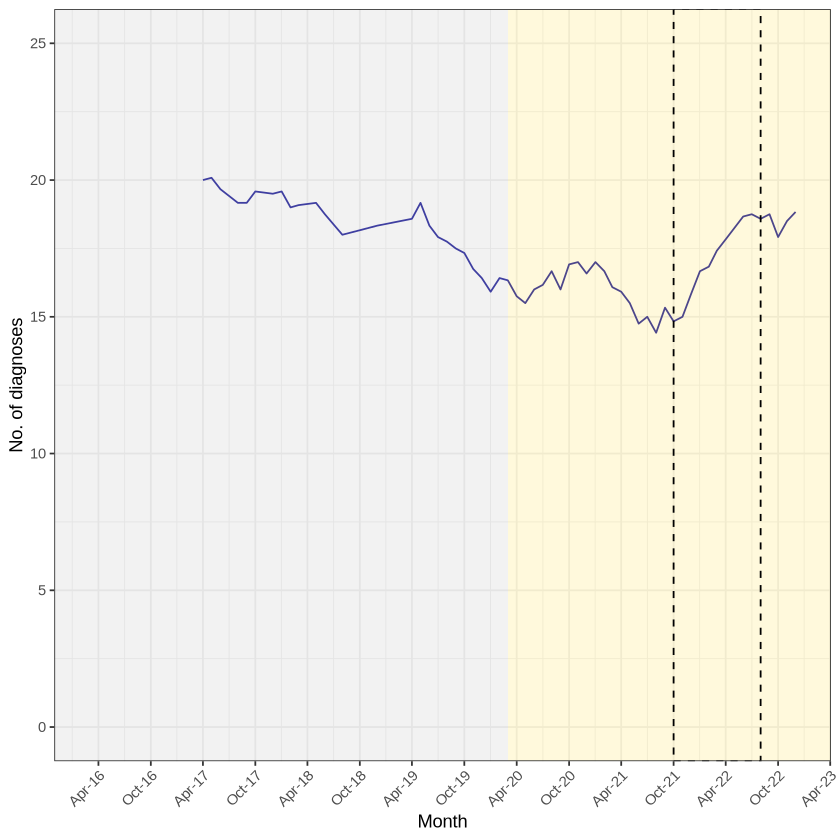

In [8]:
diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    group_by(AttendanceMonth) %>%
    summarise(n = n()) %>%
    filter(AttendanceMonth != as.Date("2023-01-01")) %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
#     geom_point() +
#     geom_line() +
    geom_ma(method = SMA, n = 12, lty = 1) +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
#         geom_vline(xintercept = c(as.Date("2016-06-01"), 
#                                   as.Date("2017-06-01"),
#                                   as.Date("2018-06-01"),
#                                   as.Date("2019-06-01"),
#                                   as.Date("2020-06-01"),
#                                   as.Date("2021-06-01"),
#                                   as.Date("2022-06-01")),
#                   color = "red") +
        theme_bw() +
        # Change date scale
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 months") +
        labs(x = "Month", y = "No. of diagnoses") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        ylim(0, 25)

ggsave("results/overall_diag_codes.pdf", dpi = 600, width = 12, height = 2)

Joining with `by = join_by(AttendanceMonth)`


n,time,treatment,timesincetreat
<dbl>,<date>,<dbl>,<dbl>
0.001552795,2016-03-01,0,0
0.001816791,2016-04-01,0,0
0.001829826,2016-05-01,0,0
0.002133333,2016-06-01,0,0
0.001417139,2016-07-01,0,0
0.001833181,2016-08-01,0,0



	Durbin-Watson test

data:  n ~ time + treatment + timesincetreat
DW = 1.5235, p-value = 0.005624
alternative hypothesis: true autocorrelation is greater than 0



Call:
lm(formula = n ~ time + treatment + timesincetreat, data = parsed)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.054e-04 -3.607e-04 -3.113e-05  3.330e-04  1.375e-03 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     5.428e-03  1.876e-03   2.893  0.00494 **
time           -2.029e-07  1.049e-07  -1.934  0.05672 . 
treatment       3.229e-05  1.988e-04   0.162  0.87135   
timesincetreat  1.637e-07  7.218e-07   0.227  0.82112   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005124 on 78 degrees of freedom
Multiple R-squared:  0.06504,	Adjusted R-squared:  0.02908 
F-statistic: 1.809 on 3 and 78 DF,  p-value: 0.1525


,2.5 %,97.5 %
(Intercept),1.692893e-03,9.162264e-03
time,-4.116815e-07,5.943660e-09
treatment,-3.634097e-04,4.279959e-04
timesincetreat,-1.273224e-06,1.600722e-06


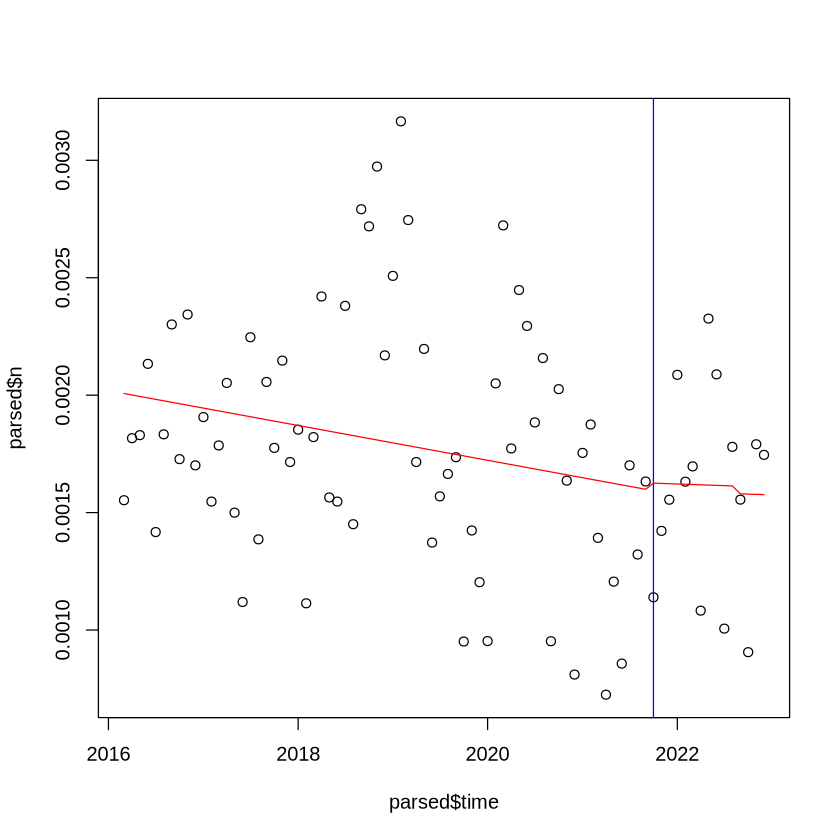

In [9]:
test <- diag_df %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    group_by(AttendanceMonth) %>%
    summarise(n = n()) %>%
    filter(AttendanceMonth != as.Date("2023-01-01")) %>%
    left_join(attendances) %>%
    mutate(n = n / n_attended)

# ITS
intervention_start <- as.Date("2021-10-01")
intervention_end <- as.Date("2022-08-01")
parsed <- test %>%
    ungroup() %>%
    mutate(treatment = ifelse(AttendanceMonth <= intervention_end & AttendanceMonth >= intervention_start, 1, 0),
           timesincetreat = AttendanceMonth - intervention_start) %>%
    mutate(timesincetreat = ifelse(timesincetreat < 0, 0, timesincetreat)) %>%
    dplyr::rename(time = AttendanceMonth) %>%
    select(n, time, treatment, timesincetreat)
     

head(parsed)

# Test for autocorrelation
lmtest::dwtest(n ~ time + treatment + timesincetreat, data = parsed)

ts <- lm(n ~ time + treatment + timesincetreat, data = parsed)

plot(parsed$time, parsed$n)
abline(v = intervention_start, col = "blue")
lines(parsed$time, ts$fitted.values, col = "red")

summary(ts)
confint(ts)

### Diagnostic code trends

`summarise()` has grouped output by 'AttendanceMonth'. You can override using the `.groups` argument.
Warning message in geom_ma_(mapping = mapping, data = data, position = position, :
“Ignoring unknown parameters: `method`”
Warning message in geom_ma_(mapping = mapping, data = data, position = position, :
“Ignoring unknown parameters: `method`”


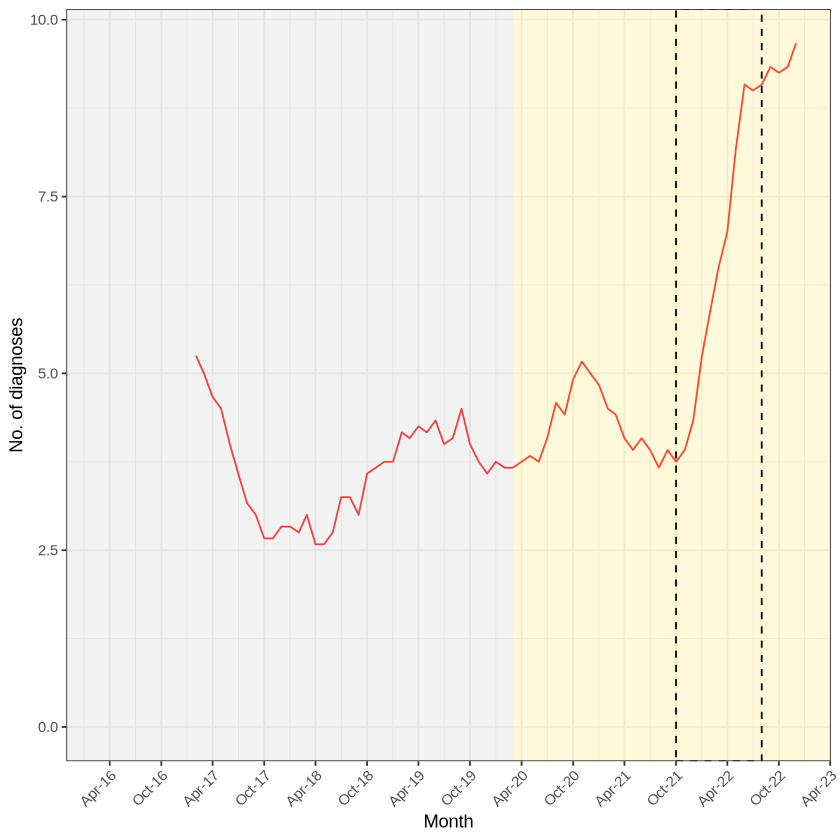

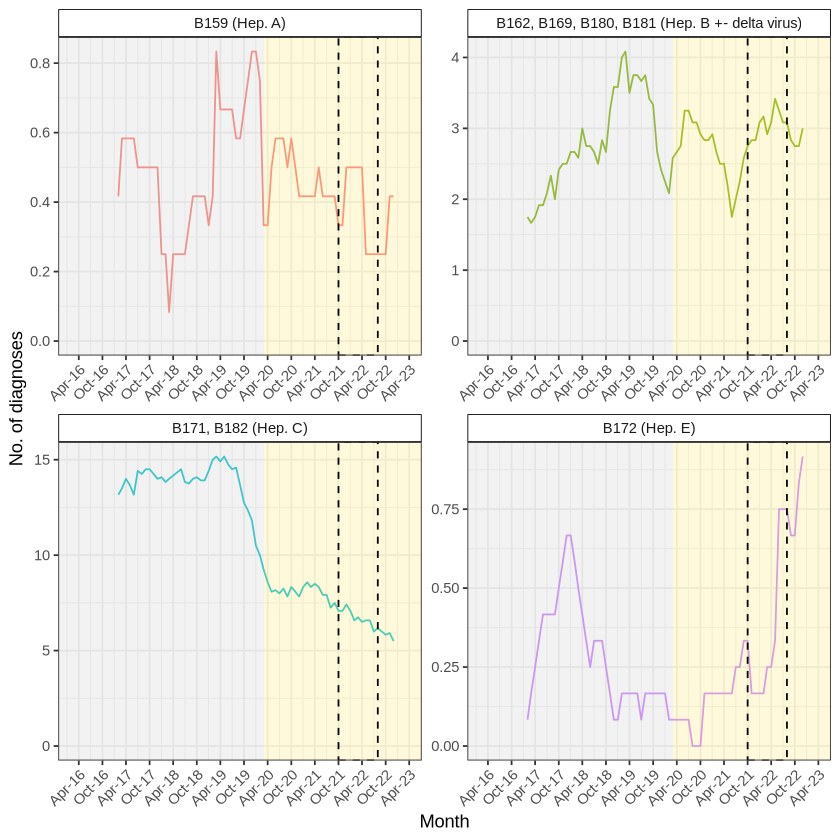

In [10]:
# Shuffle rows 
diag_df_shuffled <- as_tibble(diag_df)
diag_df_shuffled <- diag_df_shuffled[sample(rownames(diag_df_shuffled), size = nrow(diag_df_shuffled), replace = F), ]

diag_plot_df <- diag_df_shuffled %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(diag_parsed = ifelse(DiagCode %in% unspecified, "Unspecified agent", DiagCode)) %>%
    filter(!(diag_parsed %in% c("B189"))) %>%
    mutate(diag_parsed = case_when(diag_parsed == "Unspecified agent" ~ "Unspecified agent",
                                   diag_parsed == "B159" ~ "B159 (Hep. A)",
                                  diag_parsed %in% c("B171", "B182") ~ "B171, B182 (Hep. C)",
                                  diag_parsed == "B172" ~ "B172 (Hep. E)",
                                  diag_parsed %in% c("B162", "B169", "B180", "B181") ~ "B162, B169, B180, B181 (Hep. B +- delta virus)")) %>%
    mutate(diag_parsed = factor(diag_parsed, c("Unspecified agent",
                                               "B159 (Hep. A)", 
                                               "B162, B169, B180, B181 (Hep. B +- delta virus)", 
                                               "B171, B182 (Hep. C)",
                                               "B172 (Hep. E)"))) %>%
    group_by(AttendanceMonth, diag_parsed, .drop = F) %>%
    summarise(n = n())


pal <- distinctColorPalette(n_distinct(diag_plot_df$diag_parsed))

diag_plot_df %>%
    filter(diag_parsed == "Unspecified agent") %>%
    ggplot(aes(x = AttendanceMonth, y = n, color = diag_parsed)) +
#         geom_line() +
#         geom_point() +
        geom_ma(aes(color = diag_parsed), method = SMA, n = 12, lty = 1) +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 month") +
        theme_bw() +
        scale_color_manual(values = c("red", rep("black", 6))) +
        labs(x = "Month", y = "No. of diagnoses") +
        theme(legend.position = "none",
              axis.text.x = element_text(angle = 45, hjust = 1),
              strip.background=element_rect(colour = "black", fill = "white")) +
        expand_limits(y = 0)

ggsave("results/diag_codes_unspecified.pdf", dpi = 600, width = 12, height = 3)

diag_plot_df %>%
    filter(diag_parsed != "Unspecified agent") %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
#         geom_line() +
#         geom_point() +
        geom_ma(aes(color = diag_parsed), method = SMA, n = 12, lty = 1) +
        facet_wrap(~ diag_parsed, ncol = 2, scales = "free") +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 month", limits = c(as.Date("2016-03-01"), as.Date("2023-03-01"))) +
        theme_bw() +
#         scale_color_manual(values = c("red", rep("black", 6))) +
        labs(x = "Month", y = "No. of diagnoses") +
        theme(legend.position = "none",
              axis.text.x = element_text(angle = 45, hjust = 1),
              strip.background=element_rect(colour = "black", fill = "white")) +
        expand_limits(y = 0)

ggsave("results/diag_codes_specified.pdf", dpi = 600, width = 12, height = 4)

### ITS for AHUA

Joining with `by = join_by(AttendanceMonth)`


n,time,treatment,timesincetreat
<dbl>,<date>,<dbl>,<dbl>
0.0004313320,2016-03-01,0,0
0.0009562058,2016-04-01,0,0
0.0004158696,2016-05-01,0,0
0.0006222222,2016-06-01,0,0
0.0005001667,2016-07-01,0,0
0.0005499542,2016-08-01,0,0



	Durbin-Watson test

data:  n ~ time + treatment + timesincetreat
DW = 1.8686, p-value = 0.1756
alternative hypothesis: true autocorrelation is greater than 0



Call:
lm(formula = n ~ time + treatment + timesincetreat, data = parsed)

Residuals:
       Min         1Q     Median         3Q        Max 
-5.169e-04 -1.921e-04 -8.760e-06  1.597e-04  5.904e-04 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)    1.450e-04  8.873e-04   0.163  0.87059   
time           1.334e-08  4.961e-08   0.269  0.78867   
treatment      2.504e-04  9.401e-05   2.663  0.00939 **
timesincetreat 7.363e-07  3.414e-07   2.157  0.03411 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0002424 on 78 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2358 
F-statistic: 9.331 on 3 and 78 DF,  p-value: 2.418e-05


,2.5 %,97.5 %
(Intercept),-1.62e-03,1.91e-03
time,-8.54e-08,1.12e-07
treatment,6.32e-05,4.38e-04
timesincetreat,5.66e-08,1.42e-06



	Shapiro-Wilk normality test

data:  ts$resid
W = 0.98191, p-value = 0.3016


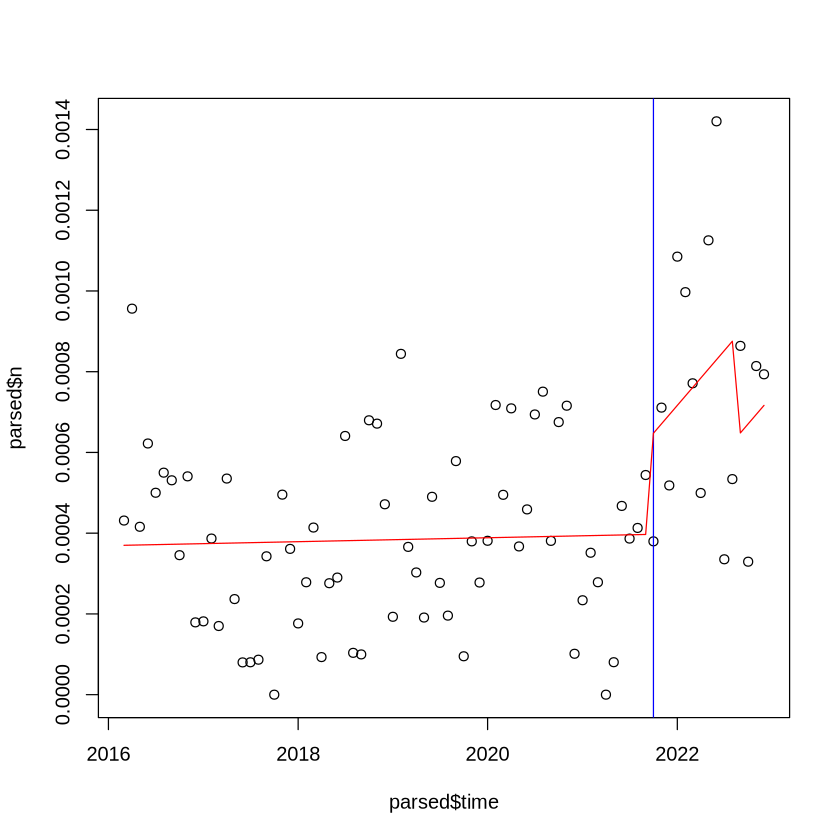

In [11]:
test <- diag_plot_df %>%
    filter(diag_parsed == "Unspecified agent")  %>%
    left_join(attendances) %>%
    mutate(n = n / n_attended)

# ITS
intervention_start <- as.Date("2021-10-01")
intervention_end <- as.Date("2022-08-01")
parsed <- test %>%
    ungroup() %>%
    mutate(treatment = ifelse(AttendanceMonth <= intervention_end & AttendanceMonth >= intervention_start, 1, 0),
           timesincetreat = AttendanceMonth - intervention_start) %>%
    mutate(timesincetreat = ifelse(timesincetreat < 0, 0, timesincetreat)) %>%
    dplyr::rename(time = AttendanceMonth) %>%
    select(n, time, treatment, timesincetreat)
     

head(parsed)

# Test for autocorrelation
lmtest::dwtest(n ~ time + treatment + timesincetreat, data = parsed)

ts <- lm(n ~ time + treatment + timesincetreat, data = parsed)

plot(parsed$time, parsed$n)
abline(v = intervention_start, col = "blue")
lines(parsed$time, ts$fitted.values, col = "red")

summary(ts)
signif(confint(ts), 3)

shapiro.test(ts$resid)

### ITS for viral hep A-E

n,time,treatment,timesincetreat
<int>,<date>,<dbl>,<dbl>
13,2016-03-01,0,0
9,2016-04-01,0,0
17,2016-05-01,0,0
17,2016-06-01,0,0
11,2016-07-01,0,0
14,2016-08-01,0,0



	Durbin-Watson test

data:  n ~ time + treatment + timesincetreat
DW = 1.869, p-value = 0.1761
alternative hypothesis: true autocorrelation is greater than 0



Call:
lm(formula = n ~ time + treatment + timesincetreat, data = parsed)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.4449 -2.7879 -0.2857  2.5485 11.7427 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    79.4239181 16.8460779   4.715 1.04e-05 ***
time           -0.0036099  0.0009419  -3.833 0.000255 ***
treatment      -0.7846483  1.7849000  -0.440 0.661440    
timesincetreat  0.0003283  0.0064818   0.051 0.959735    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.602 on 78 degrees of freedom
Multiple R-squared:  0.2701,	Adjusted R-squared:  0.2421 
F-statistic: 9.623 on 3 and 78 DF,  p-value: 1.771e-05


,2.5 %,97.5 %
(Intercept),45.90000,113.00000
time,-0.00549,-0.00173
treatment,-4.34000,2.77000
timesincetreat,-0.01260,0.01320



	Shapiro-Wilk normality test

data:  ts$residuals
W = 0.98128, p-value = 0.2762


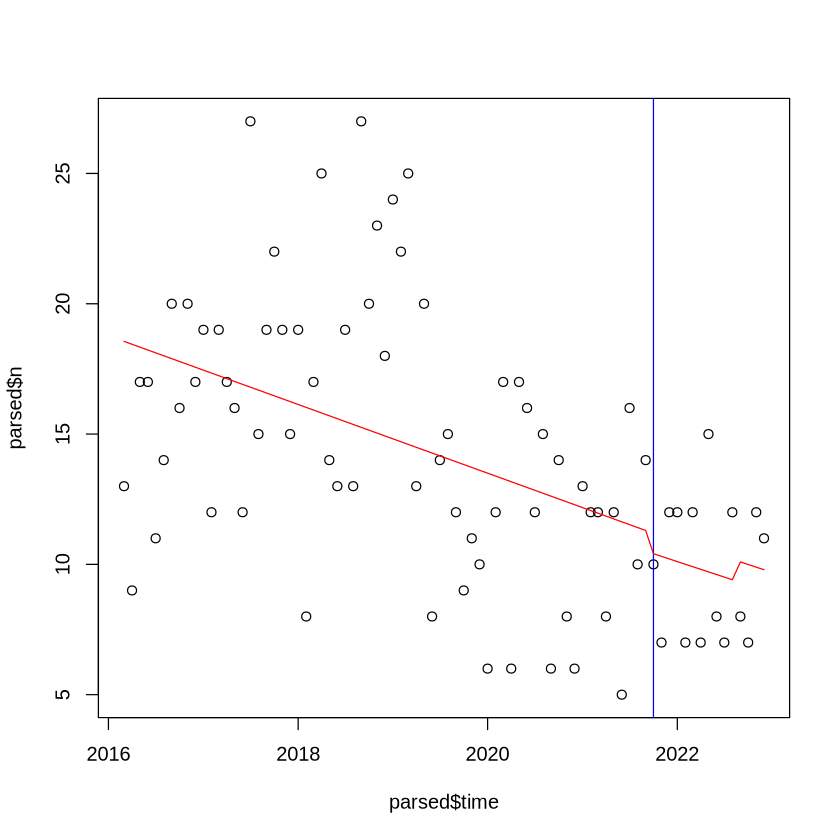

In [12]:
test <- diag_plot_df %>%
    filter(diag_parsed != "Unspecified agent") %>%
    group_by(AttendanceMonth) %>%
    summarise(n = sum(n))

# ITS
intervention_start <- as.Date("2021-10-01")
intervention_end <- as.Date("2022-08-01")
parsed <- test %>%
    ungroup() %>%
    mutate(treatment = ifelse(AttendanceMonth <= intervention_end & AttendanceMonth >= intervention_start, 1, 0),
           timesincetreat = AttendanceMonth - intervention_start) %>%
    mutate(timesincetreat = ifelse(timesincetreat < 0, 0, timesincetreat)) %>%
    dplyr::rename(time = AttendanceMonth) %>%
    select(n, time, treatment, timesincetreat)
     

head(parsed)

# Test for autocorrelation
lmtest::dwtest(n ~ time + treatment + timesincetreat, data = parsed)

ts <- lm(n ~ time + treatment + timesincetreat, data = parsed)
plot(parsed$time, parsed$n)
abline(v = intervention_start, col = "blue")
lines(parsed$time, ts$fitted.values, col = "red")

summary(ts)
signif(confint(ts), 3)

# Test for normality
shapiro.test(ts$residuals)

In [13]:
diag_plot_df %>%
    ungroup() %>%
    mutate(diag_parsed = factor(diag_parsed, c("Unspecified agent",
                                               "B159 (Hep. A)", "B169 (Hep. B)", "B171 (Hep. C)",
                                                "B172 (Hep. E)", "B180, B181 (Hep. B +- delta virus)", "B182 (Hep. C)"))) %>%
    group_by(diag_parsed) %>%
    summarise(n = sum(n)) %>%
    summarise(sum(n))

sum(n)
<int>
1572


In [14]:
diag_plot_df %>%
    filter(AttendanceMonth == as.Date("2021-10-01"))

diag_plot_df %>%
    filter(AttendanceMonth == as.Date("2022-05-01"))

AttendanceMonth,diag_parsed,n
<date>,<fct>,<int>
2021-10-01,Unspecified agent,5
2021-10-01,B159 (Hep. A),1
2021-10-01,"B162, B169, B180, B181 (Hep. B +- delta virus)",2
2021-10-01,"B171, B182 (Hep. C)",7
2021-10-01,B172 (Hep. E),0


AttendanceMonth,diag_parsed,n
<date>,<fct>,<int>
2022-05-01,Unspecified agent,15
2022-05-01,B159 (Hep. A),0
2022-05-01,"B162, B169, B180, B181 (Hep. B +- delta virus)",6
2022-05-01,"B171, B182 (Hep. C)",8
2022-05-01,B172 (Hep. E),1


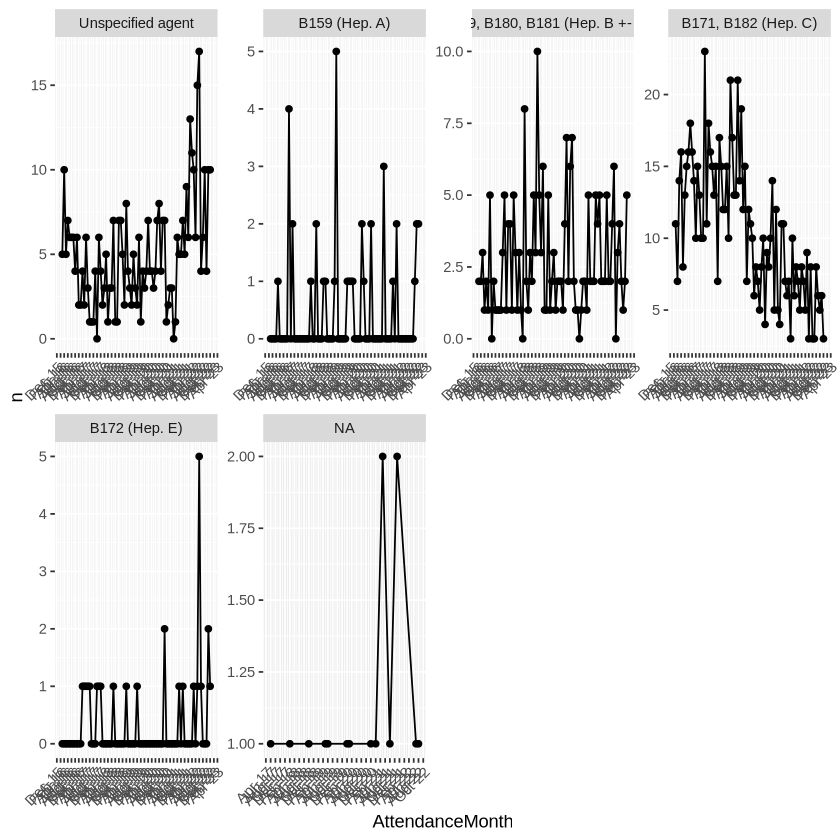

In [15]:
diag_plot_df %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
    geom_point() +
    geom_line() +
    facet_wrap(~ diag_parsed, ncol = 4, scales = "free") +
    scale_x_date(date_labels="%b-%y", date_breaks  = "2 month") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggsave("results/diag_codes_incidence.pdf", width = 30, height =5)

In [16]:
# diag_plot_df2 %>%
#     group_by(age_group) %>%
#     summarise(total_counts = sum(n)) %>%
#     mutate(prop = total_counts / sum(total_counts))
# #     ggplot(aes(x = "", y = total_counts, fill = age_group)) +
# #     geom_bar(width = 1, stat = "identity") +
# #     coord_polar("y", start=0)

### ALT per diagnostic code per month

In [17]:
# "K720", "K759", "K716", "B199", "B179"

In [19]:
# at_df %>% 
#     left_join(test_df) %>%
#     select(ClusterID, AttendanceStartDate, CollectionMonth, TestName, LinkedSex, Value) %>%
#     filter(TestName == "ALT",
#            LinkedSex %in% c("M", "F")) %>%
#     mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
#     left_join(age_df %>% select(ClusterID, AttendanceStartDate, age_upon_presentation)) %>%
#     arrange(AttendanceStartDate) %>%
#     mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
#     mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
#                                  age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
#                                  age_upon_presentation >= 16 ~ ">15"),
#            Value = as.numeric(Value)) %>%
#     # Replace <6, <30 with 0.0001 to prevent divide by zero error
#     mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
#     # Define ULN values
#     mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
#     # Get fold difference
#     mutate(ALT_fold = Value / ULN) %>%
#     mutate(ALT_class = case_when(ALT_fold <= 1 ~ "<=1x ULN",
#                                  ALT_fold > 1 & ALT_fold <= 2 ~ "1-2x ULN",
#                                  ALT_fold >= 2 & ALT_fold <= 5 ~ "2-5x ULN",
#                                  ALT_fold >= 5 & Value <= 500 ~ "5x ULN-500IU/L",
#                                  Value > 500 ~ ">500IU/L")) %>%
#     left_join(diag_df %>% select(ClusterID, AttendanceStartDate, DiagCode))

In [20]:
ALT_class_df <- at_df %>% 
    left_join(test_df) %>%
    select(ClusterID, AttendanceStartDate, CollectionMonth, TestName, LinkedSex, Value) %>%
    filter(TestName == "ALT",
           LinkedSex %in% c("M", "F")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df %>% select(ClusterID, AttendanceStartDate, age_upon_presentation)) %>%
    arrange(AttendanceStartDate) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value)) %>%
    # Replace <6, <30 with 0.0001 to prevent divide by zero error
    mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
    # Define ULN values
    mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
    # Get fold difference
    mutate(ALT_fold = Value / ULN) %>%
    mutate(ALT_class = case_when(ALT_fold <= 1 ~ "<=1x ULN",
                                 ALT_fold > 1 & ALT_fold <= 2 ~ "1-2x ULN",
                                 ALT_fold >= 2 & ALT_fold <= 5 ~ "2-5x ULN",
                                 ALT_fold >= 5 & Value <= 500 ~ "5x ULN-500IU/L",
                                 Value > 500 ~ ">500IU/L")) %>%
    left_join(diag_df %>% select(ClusterID, AttendanceStartDate, AttendanceMonth, DiagCode)) %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(CollectionMonth = as.Date(CollectionMonth),
           AttendanceMonth = as.Date(AttendanceMonth))


ERROR: Error in eval(expr, envir, enclos): object 'at_df' not found


In [ ]:
ALT_class_df

In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN") %>%
a    filter(!(DiagCode %in% c("B162", "B178", "K752", "B189", "B180", "B188"))) %>%
    group_by(AttendanceMonth, DiagCode) %>%
    summarise(n = n())

In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN") %>%
    filter(!(DiagCode %in% c("B162", "B178", "K752", "B189", "B180", "B188"))) %>%
    group_by(AttendanceMonth, DiagCode) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = AttendanceMonth, y = n, color = DiagCode)) +
    geom_line() +
    geom_point() +
    facet_wrap(~DiagCode)
    

In [ ]:
# only_NA <- ALT_class_df %>%
#     arrange(DiagCode) %>%
#     distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
#     filter(ALT_class != "<=1x ULN",
#            is.na(DiagCode),
#            CollectionMonth < as.Date("2023-01-01")) %>%
#     distinct(ClusterID)

# ALT_class_df %>%
# #     filter(ClusterID %in% only_NA$ClusterID) %>%
# #     group_by(ClusterID, AttendanceStartDate) %>%
# #     summarise(n = n_distinct(DiagCode)) %>%
# #     arrange(desc(n))
#     filter(ClusterID == 372998)

# ALT_class_df %>%
#     filter(ClusterID %in% only_NA$ClusterID) %>%
#     group_by(ClusterID, AttendanceStartDate) %>%
#     summarise(n = n_distinct(DiagCode)) %>%
#     arrange(desc(n))


In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN",
#            is.na(DiagCode),
           AttendanceMonth < as.Date("2023-01-01"))
#     group_by(AttendanceMonth) %>%
#     summarise(n = n())

In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN",
           is.na(DiagCode),
           AttendanceMonth < as.Date("2023-01-01")) %>%
    group_by(AttendanceMonth) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = AttendanceMonth, y = n)) +
#     facet_grid(rows = "age_group", scales = "free") +
    geom_line(color = "blue") +
    geom_point(color = "blue") +
    geom_ma(n = 12, 
            color = "red", 
            lty = 2) +
        annotate("rect",
                 xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
                 ymin = -Inf, ymax = Inf,
                 fill = "grey83",
                 alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
#         scale_color_manual(values = pal) +
        labs(x = "Two-month intervals", y = "No. of patients") +
        theme(legend.position = "none")
    

In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN") %>%
    filter(!(DiagCode %in% c("B162", "B178", "K752", "B189", "B180", "B188"))) %>%
    arrange(ClusterID) %>%
    group_by(CollectionMonth, DiagCode) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = CollectionMonth, y = n, color = DiagCode)) +
    facet_wrap(~DiagCode, scale = "free") +
    geom_point() +
    geom_line()